# Experiments on the grid map

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

import sys
sys.path.append('../')

from MAPF import SpaceTimeAStar, MultiAgentAStar, CBS, PBS

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [2]:
def prune_obstacles_from_G(G, obstacle_ratio, max_iter=100):
    '''
        Putting blocked nodes on the graph G can be viewed equivalently as removing those
        blocked nodes, along with their connections to other nodes, from the graph.
    '''
    G_pruned = deepcopy(G)

    for _ in range(max_iter):
        obstacle_num = int(obstacle_ratio * G.number_of_nodes())
        obstacles = np.random.choice(range(n_nodes),size = obstacle_num, replace = False)

        for obs in obstacles:
            G_pruned.remove_node(obs)

        if nx.is_connected(G_pruned):
            return G_pruned, obstacles 
    return None

In [184]:
n_nodes = 400
# n_nodes = 16
obstacle_ratio = 0.1


ldim = int(np.ceil(np.sqrt(n_nodes)))
udim = int(np.floor(np.sqrt(n_nodes)))

G = nx.grid_graph([ldim,udim])
G = nx.convert_node_labels_to_integers(G)
for i in G: # Add self-loops to allow the agent staying at the node.
    G.add_edge(i,i)


In [7]:
G_pruned, obs = prune_obstacles_from_G(G,obstacle_ratio)

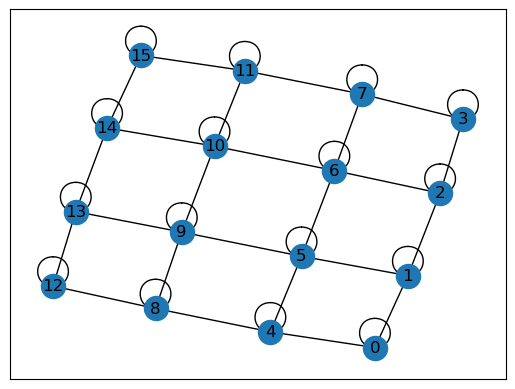

In [133]:
nx.draw_networkx(G)

In [135]:
start_nodes

(6, 5, 15, 11, 2)

In [134]:
goal_nodes

(15, 5, 3, 14, 11)

In [200]:
from tqdm import trange
from functools import partial

In [229]:
n_agents = 100

start_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) # Must be hashable.

goal_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) 

# print(start_nodes,goal_nodes)
labeled_goals = True 

messages = ['CBS', 'PBS: Depth First', 'PBS: Best First']
algs = [partial(CBS,max_iter=8000,check_edge_conflicts=True),
        partial(PBS,search_type = 'depth_first'),
        partial(PBS,search_type = 'best_first'),
       ]

for i in trange((len(algs))):
    print(messages[i], algs[i](G,start_nodes,goal_nodes))

 33%|███████████████                              | 1/3 [00:51<01:42, 51.28s/it]

Total iterations =  8001 OPEN empty? False
CBS None


 67%|██████████████████████████████               | 2/3 [01:13<00:34, 34.47s/it]

PBS: Depth First ([[295, 315, 335, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 314, 334], [259, 239, 238, 218, 198, 178, 158, 138, 118, 98, 78, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 45], [92, 93, 94, 95, 96, 97, 98, 99, 119, 139, 159, 179, 199, 219], [43, 63, 64, 64, 84, 104, 124, 144, 164, 184, 204, 205, 225, 245, 265, 285, 286, 287, 288, 308, 308], [10, 9, 8, 7, 27, 47, 67, 87, 107, 127, 147, 167, 187, 207], [233, 213, 193, 173, 153, 133, 113, 93, 73, 53, 54, 55, 56, 36, 37, 36, 37, 37], [147, 148, 149, 169, 149, 150, 130, 131, 132, 133, 134, 135, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 136, 137], [101, 102, 122, 142, 143, 144, 164, 165, 166, 167, 168, 188, 208, 209, 229, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 258, 278, 298, 299, 319], [204, 184, 164, 163, 162, 142, 122, 121], [356, 336, 316, 315, 314, 313, 312, 311, 310, 290, 289, 288, 288, 268, 267, 266, 246, 226, 206, 186, 166, 165, 165], [329, 30

100%|█████████████████████████████████████████████| 3/3 [02:07<00:00, 42.55s/it]

Total iterations =  2001 OPEN empty? False
PBS: Best First None
